# Time-lapse tracer experiment in sand column
In this experiment, time-lapse ERT is used to monitor the infiltration of a tracer in a sand column.
The tracer is tap water with an electrical conductivity (EC) of 2000 $\mu$S/cm. The tracer is injected from the top of the column to simulate heavy rainfall at a rate of 40 mm/h. Electrodes are placed in 8 rings of 12 electrodes along the column. ERT dataset are collected every 41.22 seconds with 250 ms on-time.
Plan of the experimental setup:

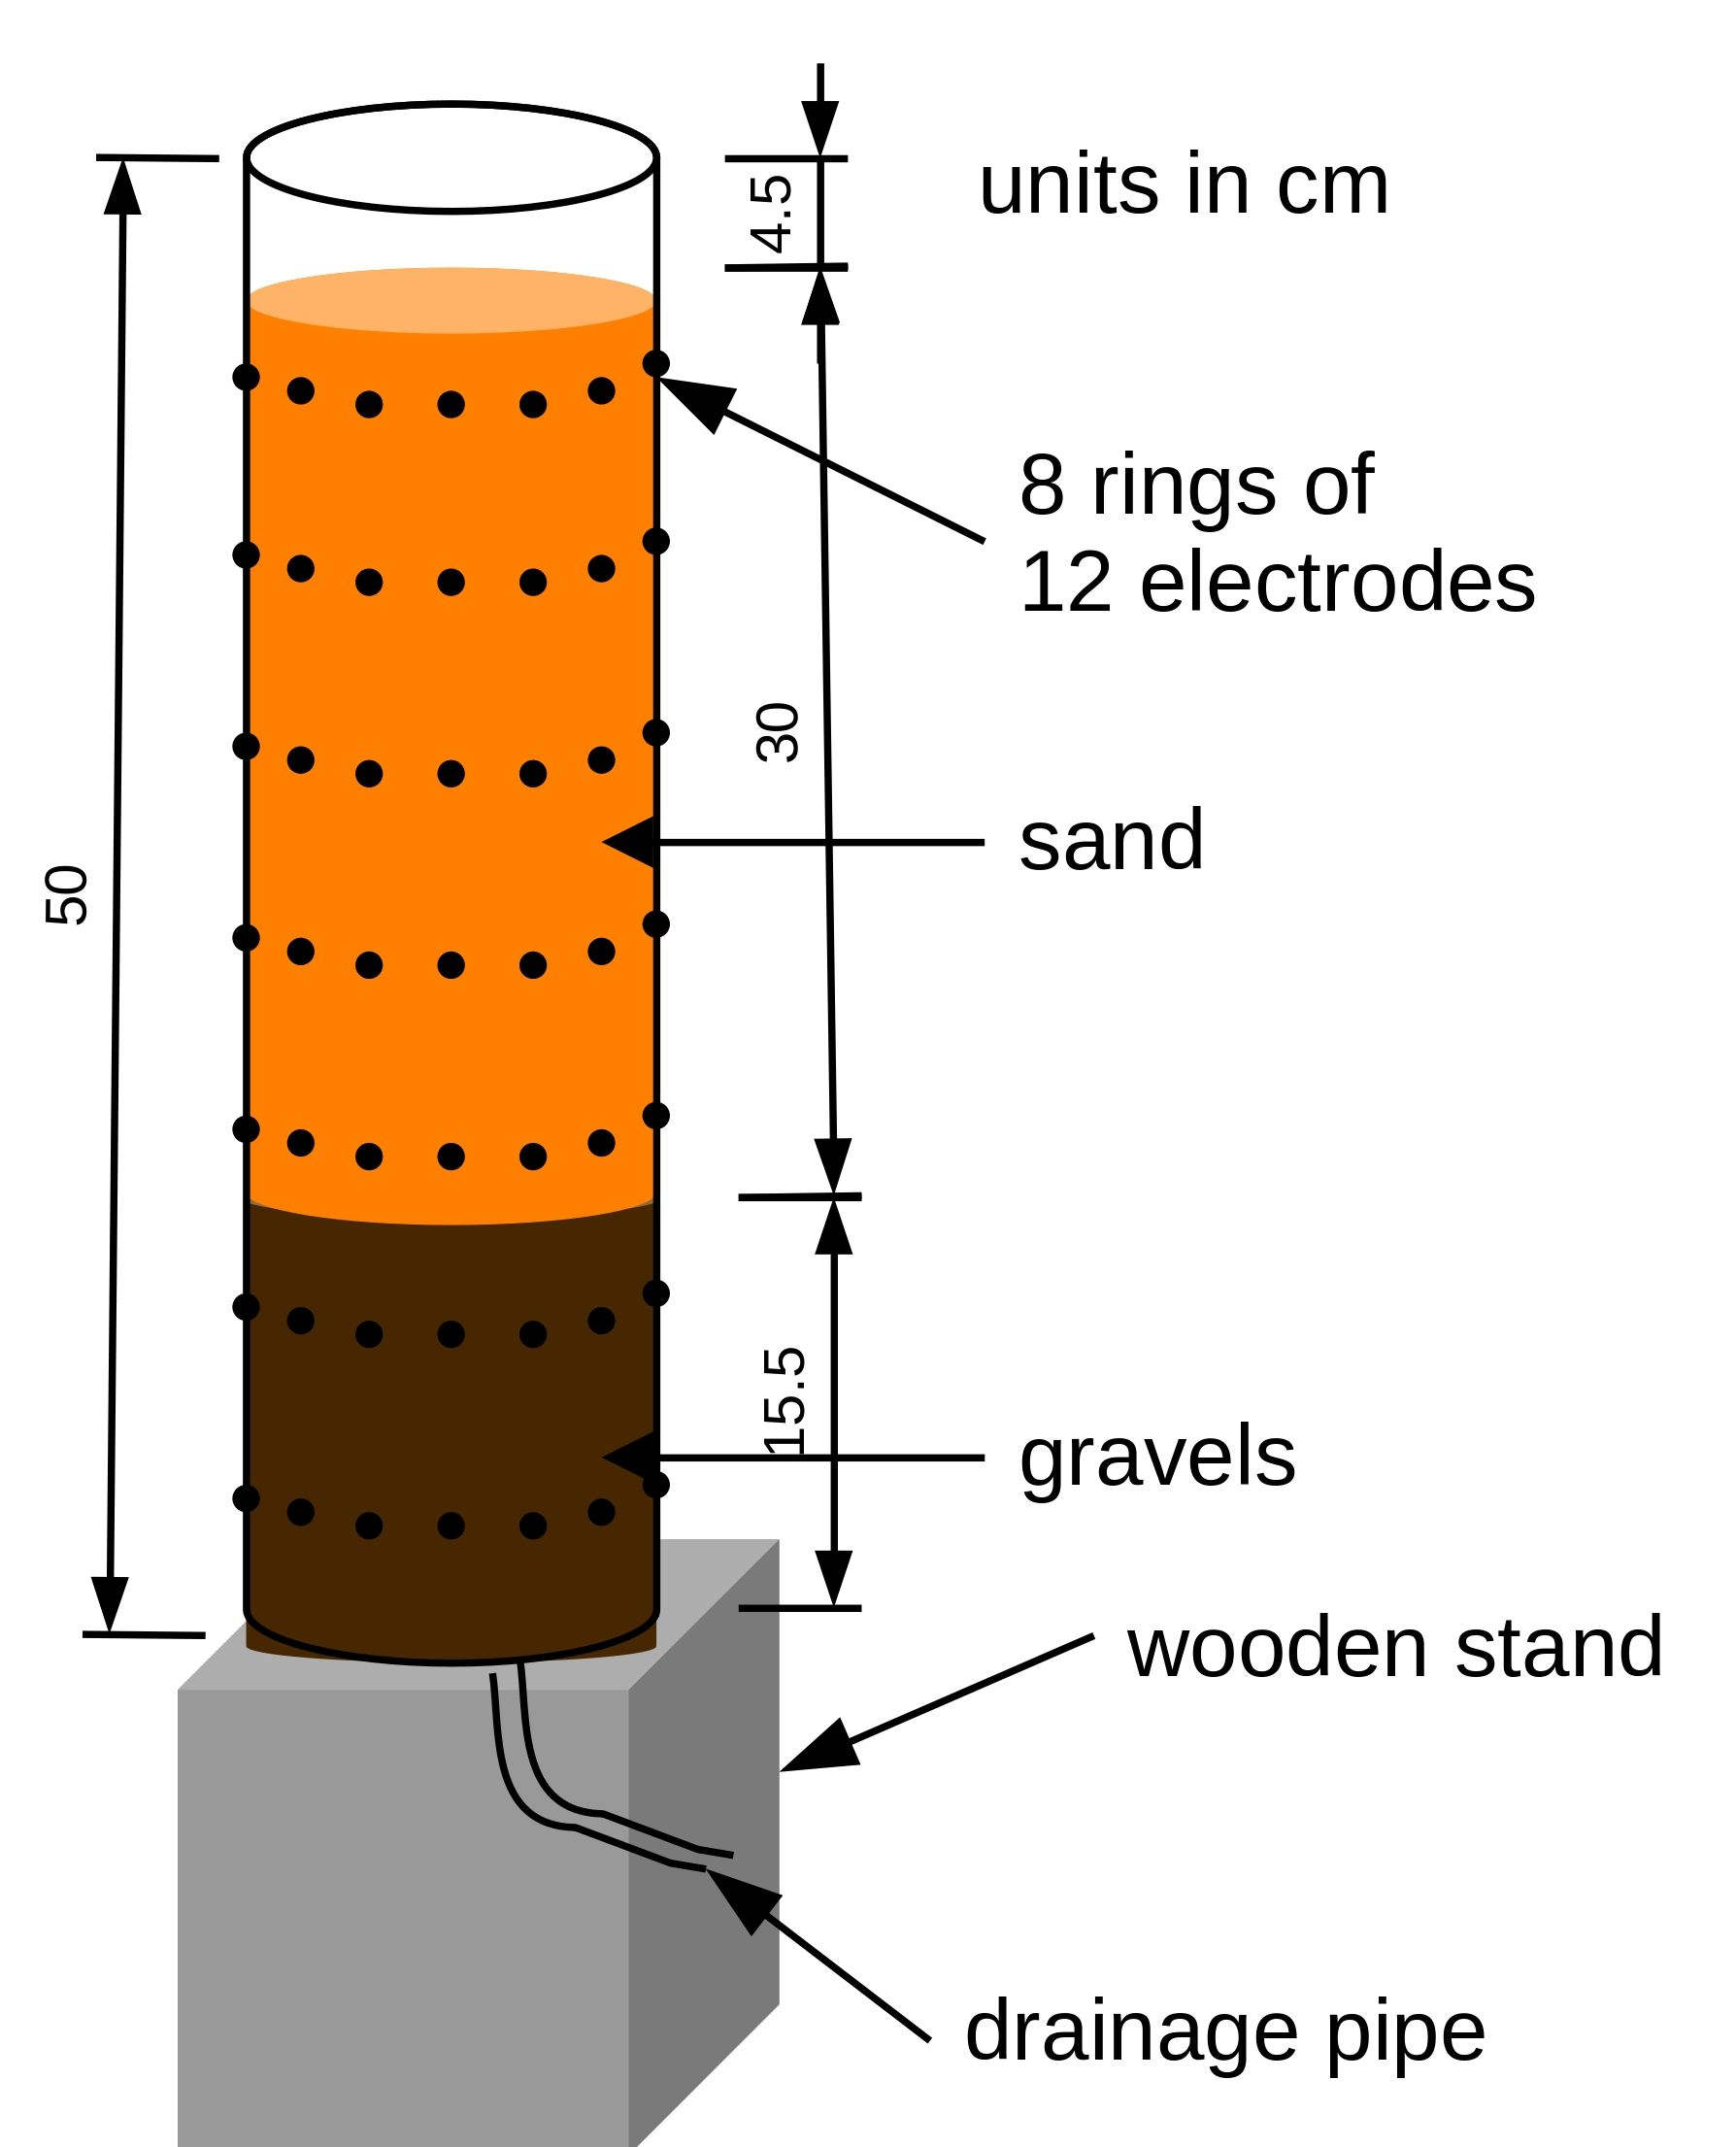

In [1]:
 # trick to import a resipy from a local copy (you won't need that if you `pip install resipy`)
import sys 
sys.path.append('../src')

import os
from resipy import Project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv

datadir = '../src/examples/dc-3d-timelapse-column/'
wd = '../src/resipy/invdir/'

API path =  /media/jkl/data/phd/tmp/resipy/src/resipy
ResIPy version =  3.2.3
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


In [2]:
# helper functions for plotting
def showOutflow(fname, ax=None, label=''):
    """Plot outflow EC with time.
    """
    df = pd.read_csv(fname, header=2, sep=' ')
    df['hh:mm:ss'] = pd.to_datetime(df['hh:mm:ss'])
    df['t'] = [(a - df['hh:mm:ss'].values[0]).seconds for a in df['hh:mm:ss']]
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(df['t'], df['mS'], '.-', label=label)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('mS')

def showEvol(k, dt=2, ax=None): # dt is time interval in seconds
    """Plot resistivity per ring with time.
    """
    vals = np.vstack([s.df['resist'].values[0::20] for s in k.surveys])
    xx = np.arange(0, len(k.surveys))*dt
    if ax == None:
        fig, ax = plt.subplots()
    for i in range(vals.shape[1]):
        ax.semilogy(xx, vals[:,i], '.-', label='ring {:d}'.format(i+1))
    ax.set_xlabel('Time [s]')
    ax.legend()
    ax.set_ylabel(r'Transfer Resistance [$\Omega$]')

In [3]:
# each survey last 41.22 s
k = Project(typ='R3t')
k.createTimeLapseSurvey(datadir + 'data/', ftype='ProtocolDC')
k.importElec(datadir + 'elec.csv')

Working directory is: /media/jkl/data/phd/tmp/resipy/src/resipy
clearing dirname
9/9 imported


In [4]:
k.importMesh(datadir + 'mesh.msh')
# k.param['node_elec'] = np.c_[np.arange(len(ielec))+1, ielec+1]
k.param['num_xy_poly'] = 0
k.param['xy_poly_table'] = []
k.param['zmin'] = -10
k.param['zmax'] = 50
k.invert(parallel=True)

Writing .in file and protocol.dat... Matching quadrupoles between surveys for difference inversion...100 in common...done in 0.030377s
done
------------ INVERTING REFERENCE SURVEY ---------------


KeyboardInterrupt: 

In [ ]:
res0 = np.array(k.meshResults[0].df['Resistivity(ohm.m)'])
for i, m in enumerate(k.meshResults):
    res = np.array(m.df['Resistivity(ohm.m)'])
    m.df['difference(percent)'] = list((res-res0)/res0*100)
    m.vtk(wd + 'out{:03d}.vtk'.format(i))
    print('\r{:d}/{:d} written'.format(i+1, len(k.meshResults)), end='')
print('\n')

(0.0, 16186.8)

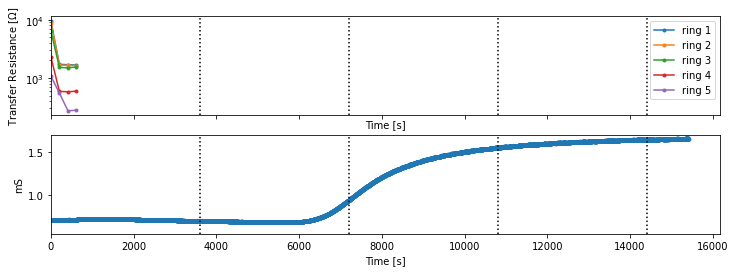

In [19]:
# vizualise resistance on each ring and EC of the outflow with time
steps = np.array([60, 120, 180, 240])*60
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,4))
showEvol(k, dt=41.25*5*5, ax=axs[0])
[axs[0].axvline(a, color='k', linestyle=':') for a in steps]
showOutflow(datadir + 'outflow/20030201.txt', ax=axs[1])
[axs[1].axvline(a, color='k', linestyle=':') for a in steps]
axs[1].set_ylim([0.55, 1.7])
axs[1].set_xlim([0, None])

In [ ]:
pl = pv.Plotter(notebook=True)
for i in range(1, len(k.surveys)):
    offset = i*0.02
    mesh = pv.read(wd + 'out{:03d}.vtk'.format(i))
    mesh.translate([offset, 0, 0])
    pl.add_mesh(mesh, scalars='difference(percent)', cmap='blues_r', clim=(-50, 0))
    melec = pv.read(os.path.join(k.dirname, 'electrodes.vtk'))
    melec.translate([offset, 0, 0])
    pl.add_mesh(melec)
    pl.add_text('{:.0f} min'.format(41.22+i*41.22*5*5/60), position=(200 + offset*830, 600), font_size=8)
pl.set_background((0,0,0))
pl.view_xz()
pl.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


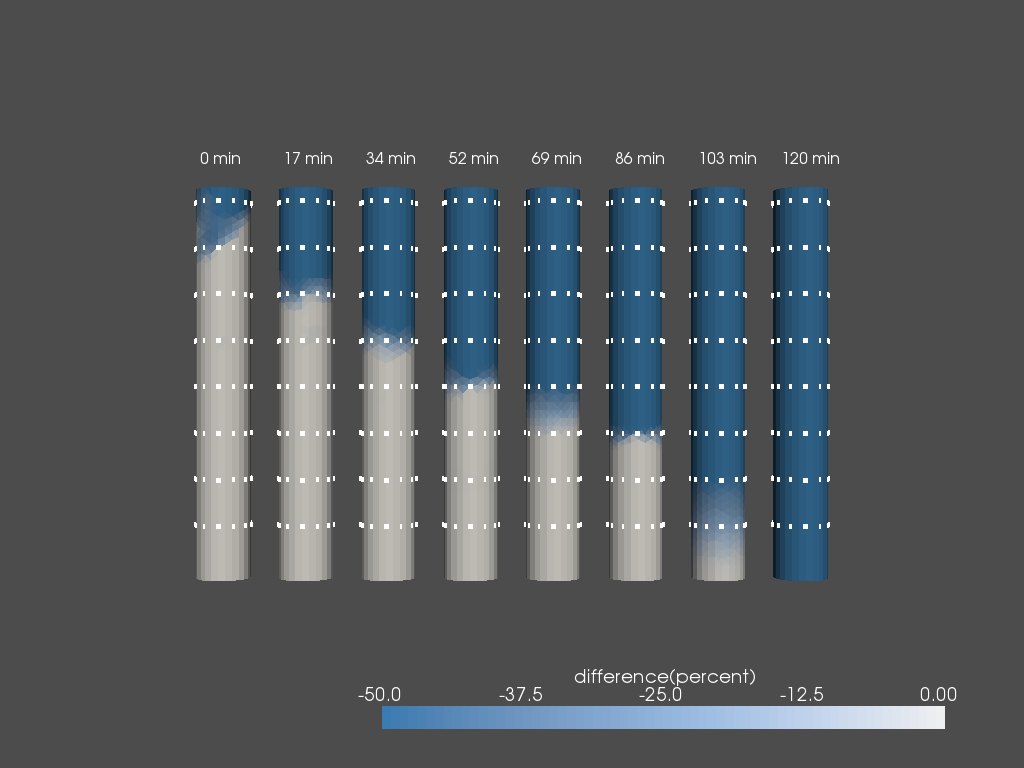

In [7]:
pl = pv.Plotter(notebook=True)
for i in np.arange(0, 40, 5):
    offset = i*0.02
    mesh = pv.read(datadir + 'out{:03d}.vtk'.format(i+1))
    mesh.translate([offset, 0, 0])
    pl.add_mesh(mesh, scalars='difference(percent)', cmap='blues_r', clim=(-50, 0))
    melec = pv.read(datadir + 'invdir/electrodes.vtk')
    melec.translate([offset, 0, 0])
    pl.add_mesh(melec)
    pl.add_text('{:.0f} min'.format(i*41.22*5/60), position=(200 + offset*830, 600), font_size=8)
pl.set_background((0,0,0))
pl.view_xz()
pl.show()

NOTE: opening all the vtk in paraview, enables to create an animated gif that shows the tracer progression in the column.

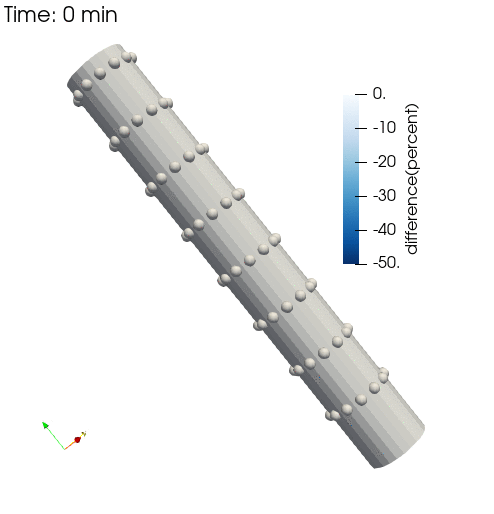